In [1]:
import numpy as np 
import pandas as pd

# matplotlib libraries

import matplotlib.pyplot as plt
# changed this to just use mplsoccer's pitch module
# from pitch import Pitch ##a helper function to quickly give us a pitch
import matplotlib.patheffects as pe 
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.patches import FancyArrowPatch

from mplsoccer.pitch import VerticalPitch
from adjustText import adjust_text

from statsbombpy import sb

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = 'Palatino Linotype'

In [4]:
sb.competitions().head(3)

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,16,4,Europe,Champions League,male,False,False,2018/2019,2023-03-07T12:20:48.118250,2021-06-13T16:17:31.694,None,2023-03-07T12:20:48.118250
1,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
2,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00


In [5]:
sb.matches(competition_id=43, season_id=106).\
    sort_values("match_date", ascending=False).\
    head(1)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
5,3869685,2022-12-18,17:00:00.000,International - FIFA World Cup,2022,Argentina,France,3,3,available,...,2022-12-21T16:02:21.075183,7,Final,Lusail Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Didier Deschamps,1.1.0,2,2


In [6]:
MATCH_ID = 3869685
df = sb.events(MATCH_ID)
df.head()

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,...,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'formation': 433, 'lineup': [{'player': {'id'...",Argentina,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",France,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,France,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Argentina,00:00:00.000,Half Start,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,France,00:00:00.000,Half Start,NaN


In [12]:
## some helper things

class AnnotationHandler(HandlerLine2D):
    """
    Copied this from https://stackoverflow.com/a/49262926 

    Useful to add a annotation entry to legend since it is not
    automatically added
    """
    def __init__(self,ms,*args,**kwargs):
        self.ms = ms
        HandlerLine2D.__init__(self,*args,**kwargs)
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):
        xdata, _ = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        ydata = ((height - ydescent) / 2.) * np.ones(np.array(xdata).shape, float)
        legline = FancyArrowPatch(posA=(xdata[0],ydata[0]),
                                  posB=(xdata[-1],ydata[-1]),
                                  mutation_scale=self.ms,
                                  **orig_handle.arrowprops)
        legline.set_transform(trans)
        return legline,

def add_arrow(x1, 
              y1, 
              x2, 
              y2, 
              ax,
              **kwargs
              ):
    """
    Helper function to add an arrow b/w two points
    defined by (x1,y1) and (x2, y2)
    """
    ax.plot([x1, x2], 
            [y1, y2], 
            **kwargs)
        
    annotation = ax.annotate("", 
                xytext=(x1, y1), 
                xy=( x1+((x2-x1)/2), 
                         y1+((y2-y1)/2)
                        ),
                arrowprops=dict(arrowstyle="->", **kwargs),
                zorder=10,
                size=30,
                label="Darker color indicates higher number of passes in that direction"
                )
    
    return annotation 

def draw_passmap(ax, 
                 team_pass_df,
                 popular_names_dict, 
                 starters, 
                 team_name, 
                 color, 
                 cmap_name):
    
    """
    create a passmap for a single team 
    """
    
    starter_ids = [starter['player']['id'] for starter in starters]
    team_pass_df = team_pass_df.query(f"player_id in {starter_ids}")

    player_location_df = team_pass_df.\
                         groupby(['player']).\
                         agg(x=('pass_start_x', 'mean'), 
                             y=('pass_start_y', 'mean'),
                             total=('pass_start_x', 'size')
                             ).\
                         reset_index()
        
    players_passes_df = team_pass_df.\
        groupby(['player', 'pass_recipient']).\
        agg(passes=('pass_start_x', 'size')).\
        reset_index()
    
    players_passes_df = players_passes_df.merge(player_location_df[['player', 'x', 'y']], 
                                        left_on='player', right_on='player').\
                                            rename(columns={'x': 'passer_x', 
                                                            'y': 'passer_y'}
                                                   )

    players_passes_df = players_passes_df.merge(player_location_df[['player', 'x', 'y']], 
                                            left_on='pass_recipient', right_on='player').\
                                                rename(columns={'x': 'recipient_x', 
                                                                'y': 'recipient_y', 
                                                                'player_x': 'player'}
                                                    ) 
    players_passes_df.drop('player_y', axis=1, inplace=True)
    players_passes_df.sort_values("passes", ascending=True, inplace=True)

    ## 
    cmap = plt.cm.get_cmap(cmap_name)
    highest_passes = players_passes_df['passes'].max()
    players_passes_df['passes_scaled'] = players_passes_df['passes']/highest_passes

    annotations = []
    LABEL = True

    for row in players_passes_df.itertuples():
        if row.passes > MIN_PASS_COUNT:

            if abs(row.recipient_y - row.passer_y) > abs(row.recipient_x - row.passer_x):
                if row.player > row.pass_recipient:
                    x_shift, y_shift = 0, ARROW_SHIFT
                else: 
                    x_shift, y_shift = 0, -ARROW_SHIFT
            else:
                if row.player > row.pass_recipient:
                    x_shift, y_shift = ARROW_SHIFT, 0
                else: 
                    x_shift, y_shift = -ARROW_SHIFT, 0

            arrow = add_arrow(x1=row.recipient_y+y_shift, 
                        y1=row.recipient_x+x_shift,
                        x2=row.passer_y+y_shift, 
                        y2=row.passer_x+x_shift,
                        ax=ax, 
                        color=cmap(row.passes_scaled), 
                        alpha=row.passes_scaled,
                        lw=row.passes_scaled*2)
            
            annotations.append(arrow)

    texts = []

    player_location_df.sort_values("total", ascending=True, inplace=True)

    for row in player_location_df.itertuples():
        ax.scatter(row.y, 
                row.x, 
                s=(row.total/player_location_df.total.max())*700,
                fc='white',
                ec=color,
                lw=5,
                zorder=100, 
                label="Size indicates total passes made by player" if LABEL else "" 
                )
        text = ax.text(row.y, 
                    row.x-4, 
                    s=popular_names_dict[row.player], 
                    ha='center', 
                    va='center', 
                    zorder=200)
                
        text.set_path_effects([pe.PathPatchEffect(offset=(2, -2), hatch='xxxx', facecolor='gray'),
                            ])
        texts.append(text)

        LABEL = False
    # use this if you have names getting plotted over each other
    # adjust_text(texts)

    # title
    title = ax.text(0, 
            130, 
            team_name, 
            color = color,
            fontsize=24, 
            zorder=250, 
            va='top',
            )
    
    ax.text(0, 
            125, 
            f"Passes from minute 0-{team_pass_df.minute.max()} (1st substitution/red card or full-time)",
            fontsize=10, 
            va='top', )
    
    ax.text(80, 
            -2, 
            f"Minimum Passes: {MIN_PASS_COUNT}",
            fontsize=10, 
            va='top',
            ha='right',
            )
    
    title.set_path_effects([pe.PathPatchEffect(offset=(1, -1), hatch='xxxx', facecolor='black'),
                            pe.PathPatchEffect(edgecolor='black', linewidth=.8, facecolor=color)
                            ])
    
    # create legend for annotations
    h, _ = ax.get_legend_handles_labels()
    annotate = annotations[-1]

    ax.legend(handles = h +[annotate], 
              handler_map={type(annotate) : AnnotationHandler(5)}, 
              loc=3)

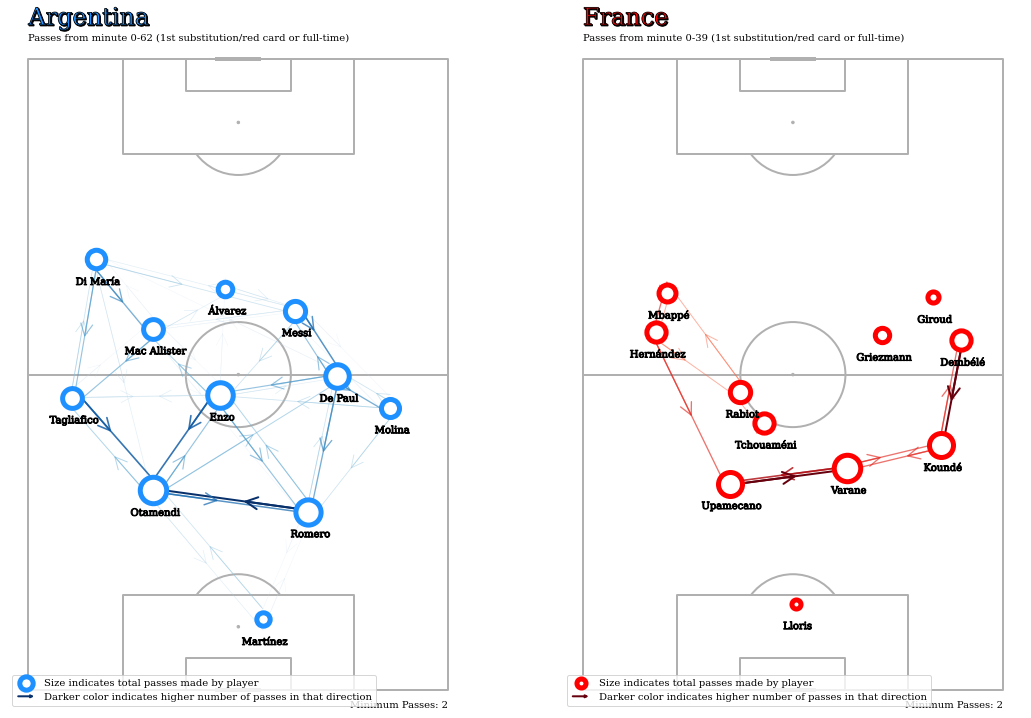

In [13]:
MIN_PASS_COUNT = 2 ##minimum number of passes for a link to be plotted
ARROW_SHIFT = 2 ## units to shift the arrows for pairs of players to ensure no overlaps

pass_df = df.query("(type == 'Pass') & \
                    (pass_type not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) & \
                    (pass_outcome not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])"
                   ).reset_index(drop=True)

pass_df[['pass_start_x','pass_start_y']] = pd.DataFrame(pass_df["location"].values.tolist(), 
                                                        index = pass_df.index)
pass_df[['pass_end_x','pass_end_y']] = pd.DataFrame(pass_df["pass_end_location"].values.tolist(), 
                                                        index = pass_df.index)

# makes it easy to get smaller names in the passmaps 
# instead of the full names
popular_names_dict = {"Alexis Mac Allister": "Mac Allister",
                      "Cristian Gabriel Romero": "Romero",
                        "Damián Emiliano Martínez": "Martínez",
                        "Enzo Fernandez": "Enzo",
                        "Julián Álvarez": "Álvarez",
                        "Lionel Andrés Messi Cuccittini": "Messi",
                        "Nahuel Molina Lucero": "Molina",
                        "Nicolás Alejandro Tagliafico": "Tagliafico",
                        "Nicolás Hernán Otamendi": "Otamendi",
                        "Rodrigo Javier De Paul": "De Paul",
                        "Ángel Fabián Di María Hernández": "Di María",
                        "Adrien Rabiot": "Rabiot",
                        "Antoine Griezmann": "Griezmann",
                        "Aurélien Djani Tchouaméni": "Tchouaméni",
                        "Dayotchanculle Upamecano": "Upamecano",
                        "Hugo Lloris": "Lloris",
                        "Jules Koundé": "Koundé",
                        "Kylian Mbappé Lottin": "Mbappé",
                        "Olivier Giroud": "Giroud",
                        "Ousmane Dembélé": "Dembélé",
                        "Raphaël Varane": "Varane",
                        "Theo Bernard François Hernández": "Hernández"
                        }

## idx, color, cmap 
idx_sides = ((0, 'dodgerblue', 'Blues'), 
             (1, 'red', 'Reds')
             )

fig, axes = VerticalPitch().draw(nrows=1, 
                       ncols=2, 
                       figsize=(16,10)
                       )
fig.set_facecolor("white")

for idx, color, cmap in idx_sides:
    starters = df.loc[idx, 'tactics']['lineup']
    team_name = df.loc[idx, 'team']
    team_pass_df = pass_df.query(f"team == '{team_name}'")

    if 'Substitution' in df.type.unique() or 'Red Card' in df.type.unique():
      ending_minute = df.query(f"team == '{team_name}' and type==('Substitution', 'Red Card')").minute.values[0]
    else: 
      ending_minute = team_pass_df.minute.max()

    team_pass_df = team_pass_df.query(f"minute<={ending_minute}")
    draw_passmap(axes[idx], 
                 team_pass_df,
                 popular_names_dict=popular_names_dict,
                 starters = starters, 
                 team_name=team_name,
                 color=color,
                 cmap_name=cmap
                 )

In [10]:
%load_ext watermark
%watermark --iversions -v

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

pandas     : 1.4.2
statsbombpy: 1.4.3
matplotlib : 3.5.2
numpy      : 1.22.4

